In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[7].mean(dim=1).cpu().numpy())
    
    return np.vstack(hidden_states)


def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:07<00:00,  3.46it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 232/232 [00:05<00:00, 43.73it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:22<00:00,  2.93it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 243/243 [00:02<00:00, 103.67it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   0%|          | 10/2000 [00:00<02:28, 13.36it/s]

Epoch 10/2000, Loss: 0.6327
Test Accuracy at Epoch 10: 65.00%
Test F1-score at Epoch 10: 0.6795
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.70      0.55      0.61       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.65       380
       macro avg       0.66      0.65      0.65       380
    weighted avg       0.66      0.65      0.65       380

New best model saved with F1-score 0.6795 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.70      0.55      0.61       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.65       380
       macro avg       0.66      0.65      0.65       380
    weighted avg       0.66      0.65      0.65       380



Training Epochs:   1%|          | 21/2000 [00:01<02:16, 14.50it/s]

Epoch 20/2000, Loss: 0.4932
Test Accuracy at Epoch 20: 70.00%
Test F1-score at Epoch 20: 0.7574
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.92      0.45      0.61       194
non_infringement       0.63      0.96      0.76       186

        accuracy                           0.70       380
       macro avg       0.77      0.71      0.68       380
    weighted avg       0.77      0.70      0.68       380

New best model saved with F1-score 0.7574 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.92      0.45      0.61       194
non_infringement       0.63      0.96      0.76       186

        accuracy                           0.70       380
       macro avg       0.77      0.71      0.68       380
    weighted avg       0.77      0.70      0.68       380



Training Epochs:   2%|▏         | 31/2000 [00:02<02:35, 12.68it/s]

Epoch 30/2000, Loss: 0.3888
Test Accuracy at Epoch 30: 76.32%
Test F1-score at Epoch 30: 0.7973
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.93      0.58      0.72       194
non_infringement       0.69      0.95      0.80       186

        accuracy                           0.76       380
       macro avg       0.81      0.77      0.76       380
    weighted avg       0.81      0.76      0.76       380

New best model saved with F1-score 0.7973 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.93      0.58      0.72       194
non_infringement       0.69      0.95      0.80       186

        accuracy                           0.76       380
       macro avg       0.81      0.77      0.76       380
    weighted avg       0.81      0.76      0.76       380



Training Epochs:   2%|▏         | 42/2000 [00:03<02:22, 13.70it/s]

Epoch 40/2000, Loss: 0.3429
Test Accuracy at Epoch 40: 80.00%
Test F1-score at Epoch 40: 0.8190
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380

New best model saved with F1-score 0.8190 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:   3%|▎         | 51/2000 [00:03<02:02, 15.92it/s]

Epoch 50/2000, Loss: 0.3050
Test Accuracy at Epoch 50: 81.58%
Test F1-score at Epoch 50: 0.8301
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380

New best model saved with F1-score 0.8301 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:   3%|▎         | 61/2000 [00:04<02:21, 13.69it/s]

Epoch 60/2000, Loss: 0.2645
Test Accuracy at Epoch 60: 81.58%
Test F1-score at Epoch 60: 0.8301
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.90      0.72      0.80       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.82      0.81       380



Training Epochs:   4%|▎         | 72/2000 [00:05<02:02, 15.68it/s]

Epoch 70/2000, Loss: 0.2418
Test Accuracy at Epoch 70: 79.47%
Test F1-score at Epoch 70: 0.8152
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.90      0.67      0.77       194
non_infringement       0.73      0.92      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:   4%|▍         | 83/2000 [00:05<01:51, 17.26it/s]

Epoch 80/2000, Loss: 0.2362
Test Accuracy at Epoch 80: 79.21%
Test F1-score at Epoch 80: 0.8184
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:   5%|▍         | 91/2000 [00:06<02:00, 15.88it/s]

Epoch 90/2000, Loss: 0.2080
Test Accuracy at Epoch 90: 79.21%
Test F1-score at Epoch 90: 0.8184
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.94      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:   5%|▌         | 101/2000 [00:06<01:47, 17.69it/s]

Epoch 100/2000, Loss: 0.1958
Test Accuracy at Epoch 100: 79.47%
Test F1-score at Epoch 100: 0.8203
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.94      0.64      0.76       194
non_infringement       0.72      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:   6%|▌         | 110/2000 [00:10<11:54,  2.64it/s]

Epoch 110/2000, Loss: 0.1815
Test Accuracy at Epoch 110: 79.47%
Test F1-score at Epoch 110: 0.8169
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:   6%|▌         | 120/2000 [00:13<07:15,  4.32it/s]

Epoch 120/2000, Loss: 0.2363
Test Accuracy at Epoch 120: 79.74%
Test F1-score at Epoch 120: 0.8180
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:   6%|▋         | 130/2000 [00:16<08:23,  3.71it/s]

Epoch 130/2000, Loss: 0.1886
Test Accuracy at Epoch 130: 78.95%
Test F1-score at Epoch 130: 0.8157
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:   7%|▋         | 141/2000 [00:17<02:35, 11.93it/s]

Epoch 140/2000, Loss: 0.1630
Test Accuracy at Epoch 140: 78.16%
Test F1-score at Epoch 140: 0.8101
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.93      0.62      0.74       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:   8%|▊         | 151/2000 [00:18<03:06,  9.89it/s]

Epoch 150/2000, Loss: 0.1467
Test Accuracy at Epoch 150: 78.42%
Test F1-score at Epoch 150: 0.8119
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.93      0.62      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:   8%|▊         | 162/2000 [00:19<02:31, 12.15it/s]

Epoch 160/2000, Loss: 0.1387
Test Accuracy at Epoch 160: 78.42%
Test F1-score at Epoch 160: 0.8119
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.93      0.62      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:   9%|▊         | 171/2000 [00:20<02:13, 13.69it/s]

Epoch 170/2000, Loss: 0.1747
Test Accuracy at Epoch 170: 78.16%
Test F1-score at Epoch 170: 0.8109
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.94      0.61      0.74       194
non_infringement       0.70      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:   9%|▉         | 184/2000 [00:20<01:21, 22.36it/s]

Epoch 180/2000, Loss: 0.1332
Test Accuracy at Epoch 180: 78.42%
Test F1-score at Epoch 180: 0.8128
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  10%|▉         | 192/2000 [00:21<01:50, 16.32it/s]

Epoch 190/2000, Loss: 0.1255
Test Accuracy at Epoch 190: 78.68%
Test F1-score at Epoch 190: 0.8146
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  10%|█         | 202/2000 [00:22<01:50, 16.32it/s]

Epoch 200/2000, Loss: 0.1233
Test Accuracy at Epoch 200: 78.68%
Test F1-score at Epoch 200: 0.8146
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  10%|█         | 210/2000 [00:22<01:47, 16.69it/s]

Epoch 210/2000, Loss: 0.1262
Test Accuracy at Epoch 210: 76.84%
Test F1-score at Epoch 210: 0.8018
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.93      0.59      0.72       194
non_infringement       0.69      0.96      0.80       186

        accuracy                           0.77       380
       macro avg       0.81      0.77      0.76       380
    weighted avg       0.81      0.77      0.76       380



Training Epochs:  11%|█         | 220/2000 [00:23<02:10, 13.62it/s]

Epoch 220/2000, Loss: 0.1286
Test Accuracy at Epoch 220: 78.95%
Test F1-score at Epoch 220: 0.8157
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  12%|█▏        | 230/2000 [00:24<01:52, 15.80it/s]

Epoch 230/2000, Loss: 0.1172
Test Accuracy at Epoch 230: 78.95%
Test F1-score at Epoch 230: 0.8157
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  12%|█▏        | 239/2000 [00:27<08:58,  3.27it/s]

Epoch 240/2000, Loss: 0.1141
Test Accuracy at Epoch 240: 78.68%
Test F1-score at Epoch 240: 0.8129
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  13%|█▎        | 251/2000 [00:30<05:44,  5.08it/s]

Epoch 250/2000, Loss: 0.1077
Test Accuracy at Epoch 250: 78.68%
Test F1-score at Epoch 250: 0.8138
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  13%|█▎        | 262/2000 [00:33<06:10,  4.69it/s]

Epoch 260/2000, Loss: 0.2964
Test Accuracy at Epoch 260: 78.42%
Test F1-score at Epoch 260: 0.8128
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  14%|█▎        | 271/2000 [00:36<07:43,  3.73it/s]

Epoch 270/2000, Loss: 0.1200
Test Accuracy at Epoch 270: 78.42%
Test F1-score at Epoch 270: 0.8057
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.89      0.66      0.76       194
non_infringement       0.72      0.91      0.81       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  14%|█▍        | 281/2000 [00:38<04:46,  6.01it/s]

Epoch 280/2000, Loss: 0.1212
Test Accuracy at Epoch 280: 78.42%
Test F1-score at Epoch 280: 0.8128
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  15%|█▍        | 294/2000 [00:39<01:22, 20.68it/s]

Epoch 290/2000, Loss: 0.1146
Test Accuracy at Epoch 290: 77.89%
Test F1-score at Epoch 290: 0.8056
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.74       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  15%|█▌        | 301/2000 [00:40<03:27,  8.20it/s]

Epoch 300/2000, Loss: 0.1067
Test Accuracy at Epoch 300: 77.89%
Test F1-score at Epoch 300: 0.8056
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.74       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  16%|█▌        | 311/2000 [00:42<05:04,  5.55it/s]

Epoch 310/2000, Loss: 0.1035
Test Accuracy at Epoch 310: 77.63%
Test F1-score at Epoch 310: 0.8037
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.91      0.62      0.74       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  16%|█▌        | 322/2000 [00:42<02:10, 12.83it/s]

Epoch 320/2000, Loss: 0.1010
Test Accuracy at Epoch 320: 77.63%
Test F1-score at Epoch 320: 0.8037
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.91      0.62      0.74       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  16%|█▋        | 330/2000 [00:44<04:45,  5.85it/s]

Epoch 330/2000, Loss: 0.0990
Test Accuracy at Epoch 330: 78.16%
Test F1-score at Epoch 330: 0.8074
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  17%|█▋        | 341/2000 [00:45<02:49,  9.79it/s]

Epoch 340/2000, Loss: 0.0973
Test Accuracy at Epoch 340: 78.16%
Test F1-score at Epoch 340: 0.8074
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  18%|█▊        | 352/2000 [00:46<02:56,  9.32it/s]

Epoch 350/2000, Loss: 0.0958
Test Accuracy at Epoch 350: 78.16%
Test F1-score at Epoch 350: 0.8074
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  18%|█▊        | 359/2000 [00:47<02:00, 13.59it/s]

Epoch 360/2000, Loss: 0.0944
Test Accuracy at Epoch 360: 78.16%
Test F1-score at Epoch 360: 0.8074
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  19%|█▊        | 374/2000 [00:49<01:40, 16.26it/s]

Epoch 370/2000, Loss: 0.0931
Test Accuracy at Epoch 370: 78.16%
Test F1-score at Epoch 370: 0.8074
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  19%|█▉        | 386/2000 [00:49<00:58, 27.70it/s]

Epoch 380/2000, Loss: 0.0919
Test Accuracy at Epoch 380: 78.16%
Test F1-score at Epoch 380: 0.8074
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.75       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.78       380
    weighted avg       0.81      0.78      0.78       380



Training Epochs:  20%|█▉        | 393/2000 [00:49<01:06, 24.29it/s]

Epoch 390/2000, Loss: 0.1146
Test Accuracy at Epoch 390: 80.00%
Test F1-score at Epoch 390: 0.8173
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       194
non_infringement       0.74      0.91      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  20%|██        | 400/2000 [00:51<04:22,  6.08it/s]

Epoch 400/2000, Loss: 0.0938
Test Accuracy at Epoch 400: 77.11%
Test F1-score at Epoch 400: 0.8009
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.91      0.61      0.73       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.77       380
       macro avg       0.81      0.77      0.77       380
    weighted avg       0.81      0.77      0.77       380



Training Epochs:  21%|██        | 413/2000 [00:52<01:59, 13.29it/s]

Epoch 410/2000, Loss: 0.0943
Test Accuracy at Epoch 410: 77.89%
Test F1-score at Epoch 410: 0.8056
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.91      0.63      0.74       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  21%|██        | 420/2000 [00:52<01:20, 19.59it/s]

Epoch 420/2000, Loss: 0.0903
Test Accuracy at Epoch 420: 77.89%
Test F1-score at Epoch 420: 0.8028
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.89      0.64      0.75       194
non_infringement       0.71      0.92      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  22%|██▏       | 435/2000 [00:55<02:23, 10.92it/s]

Epoch 430/2000, Loss: 0.0886
Test Accuracy at Epoch 430: 79.74%
Test F1-score at Epoch 430: 0.8180
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  22%|██▏       | 443/2000 [00:55<01:28, 17.52it/s]

Epoch 440/2000, Loss: 0.0877
Test Accuracy at Epoch 440: 79.47%
Test F1-score at Epoch 440: 0.8152
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.90      0.67      0.77       194
non_infringement       0.73      0.92      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  23%|██▎       | 453/2000 [00:55<01:01, 24.98it/s]

Epoch 450/2000, Loss: 0.0871
Test Accuracy at Epoch 450: 79.47%
Test F1-score at Epoch 450: 0.8160
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  23%|██▎       | 457/2000 [00:55<00:57, 26.74it/s]

Epoch 460/2000, Loss: 0.0910
Test Accuracy at Epoch 460: 79.47%
Test F1-score at Epoch 460: 0.8152
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.90      0.67      0.77       194
non_infringement       0.73      0.92      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  24%|██▎       | 471/2000 [00:58<02:37,  9.71it/s]

Epoch 470/2000, Loss: 0.0923
Test Accuracy at Epoch 470: 79.74%
Test F1-score at Epoch 470: 0.8197
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.92      0.66      0.77       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.83      0.80      0.79       380



Training Epochs:  24%|██▍       | 480/2000 [01:01<08:50,  2.87it/s]

Epoch 480/2000, Loss: 0.0850
Test Accuracy at Epoch 480: 79.21%
Test F1-score at Epoch 480: 0.8132
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.77       194
non_infringement       0.73      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  24%|██▍       | 490/2000 [01:03<05:49,  4.32it/s]

Epoch 490/2000, Loss: 0.0843
Test Accuracy at Epoch 490: 79.47%
Test F1-score at Epoch 490: 0.8152
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.90      0.67      0.77       194
non_infringement       0.73      0.92      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  25%|██▌       | 500/2000 [01:08<13:34,  1.84it/s]

Epoch 500/2000, Loss: 0.0902
Test Accuracy at Epoch 500: 80.00%
Test F1-score at Epoch 500: 0.8182
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  26%|██▌       | 510/2000 [01:11<10:42,  2.32it/s]

Epoch 510/2000, Loss: 0.0863
Test Accuracy at Epoch 510: 78.68%
Test F1-score at Epoch 510: 0.8112
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.91      0.64      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  26%|██▌       | 520/2000 [01:16<12:49,  1.92it/s]

Epoch 520/2000, Loss: 0.0894
Test Accuracy at Epoch 520: 80.00%
Test F1-score at Epoch 520: 0.8182
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  27%|██▋       | 531/2000 [01:18<02:46,  8.84it/s]

Epoch 530/2000, Loss: 0.0838
Test Accuracy at Epoch 530: 79.47%
Test F1-score at Epoch 530: 0.8160
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  27%|██▋       | 540/2000 [01:21<07:52,  3.09it/s]

Epoch 540/2000, Loss: 0.0820
Test Accuracy at Epoch 540: 79.47%
Test F1-score at Epoch 540: 0.8160
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  28%|██▊       | 550/2000 [01:25<09:59,  2.42it/s]

Epoch 550/2000, Loss: 0.0824
Test Accuracy at Epoch 550: 79.47%
Test F1-score at Epoch 550: 0.8160
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  28%|██▊       | 562/2000 [01:29<04:16,  5.60it/s]

Epoch 560/2000, Loss: 0.0888
Test Accuracy at Epoch 560: 78.95%
Test F1-score at Epoch 560: 0.8140
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.92      0.64      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  28%|██▊       | 570/2000 [01:32<08:43,  2.73it/s]

Epoch 570/2000, Loss: 0.0865
Test Accuracy at Epoch 570: 80.00%
Test F1-score at Epoch 570: 0.8199
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  29%|██▉       | 580/2000 [01:35<05:03,  4.68it/s]

Epoch 580/2000, Loss: 0.0821
Test Accuracy at Epoch 580: 80.53%
Test F1-score at Epoch 580: 0.8238
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  30%|██▉       | 590/2000 [01:39<11:28,  2.05it/s]

Epoch 590/2000, Loss: 0.0808
Test Accuracy at Epoch 590: 79.74%
Test F1-score at Epoch 590: 0.8180
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  30%|███       | 600/2000 [01:43<10:13,  2.28it/s]

Epoch 600/2000, Loss: 0.0799
Test Accuracy at Epoch 600: 79.47%
Test F1-score at Epoch 600: 0.8160
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  30%|███       | 610/2000 [01:47<08:14,  2.81it/s]

Epoch 610/2000, Loss: 0.0830
Test Accuracy at Epoch 610: 79.47%
Test F1-score at Epoch 610: 0.8160
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  31%|███       | 620/2000 [01:48<02:20,  9.80it/s]

Epoch 620/2000, Loss: 0.0793
Test Accuracy at Epoch 620: 80.26%
Test F1-score at Epoch 620: 0.8219
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  32%|███▏      | 632/2000 [01:50<02:26,  9.31it/s]

Epoch 630/2000, Loss: 0.0813
Test Accuracy at Epoch 630: 80.26%
Test F1-score at Epoch 630: 0.8219
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  32%|███▏      | 640/2000 [01:53<08:33,  2.65it/s]

Epoch 640/2000, Loss: 0.0797
Test Accuracy at Epoch 640: 80.26%
Test F1-score at Epoch 640: 0.8219
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  32%|███▎      | 650/2000 [01:57<10:52,  2.07it/s]

Epoch 650/2000, Loss: 0.0803
Test Accuracy at Epoch 650: 80.00%
Test F1-score at Epoch 650: 0.8199
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  33%|███▎      | 660/2000 [01:59<03:11,  7.00it/s]

Epoch 660/2000, Loss: 0.0789
Test Accuracy at Epoch 660: 80.26%
Test F1-score at Epoch 660: 0.8219
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  34%|███▎      | 670/2000 [02:02<09:43,  2.28it/s]

Epoch 670/2000, Loss: 0.0819
Test Accuracy at Epoch 670: 80.26%
Test F1-score at Epoch 670: 0.8219
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  34%|███▍      | 681/2000 [02:06<03:29,  6.29it/s]

Epoch 680/2000, Loss: 0.0780
Test Accuracy at Epoch 680: 80.26%
Test F1-score at Epoch 680: 0.8219
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  34%|███▍      | 690/2000 [02:09<08:27,  2.58it/s]

Epoch 690/2000, Loss: 0.0841
Test Accuracy at Epoch 690: 81.05%
Test F1-score at Epoch 690: 0.8278
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.91      0.70      0.79       194
non_infringement       0.75      0.93      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  35%|███▍      | 699/2000 [02:10<02:22,  9.15it/s]

Epoch 700/2000, Loss: 0.0863
Test Accuracy at Epoch 700: 79.21%
Test F1-score at Epoch 700: 0.8141
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  36%|███▌      | 710/2000 [02:14<09:40,  2.22it/s]

Epoch 710/2000, Loss: 0.0779
Test Accuracy at Epoch 710: 79.21%
Test F1-score at Epoch 710: 0.8141
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  36%|███▌      | 720/2000 [02:18<07:23,  2.89it/s]

Epoch 720/2000, Loss: 0.0782
Test Accuracy at Epoch 720: 80.26%
Test F1-score at Epoch 720: 0.8219
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  36%|███▋      | 730/2000 [02:22<07:05,  2.98it/s]

Epoch 730/2000, Loss: 0.0772
Test Accuracy at Epoch 730: 79.74%
Test F1-score at Epoch 730: 0.8180
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  37%|███▋      | 743/2000 [02:24<01:55, 10.89it/s]

Epoch 740/2000, Loss: 0.0771
Test Accuracy at Epoch 740: 79.74%
Test F1-score at Epoch 740: 0.8180
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  38%|███▊      | 751/2000 [02:27<04:40,  4.45it/s]

Epoch 750/2000, Loss: 0.0780
Test Accuracy at Epoch 750: 79.21%
Test F1-score at Epoch 750: 0.8141
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  38%|███▊      | 761/2000 [02:28<02:49,  7.30it/s]

Epoch 760/2000, Loss: 0.0793
Test Accuracy at Epoch 760: 80.53%
Test F1-score at Epoch 760: 0.8238
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.78       194
non_infringement       0.74      0.93      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  38%|███▊      | 770/2000 [02:31<08:07,  2.52it/s]

Epoch 770/2000, Loss: 0.0811
Test Accuracy at Epoch 770: 79.21%
Test F1-score at Epoch 770: 0.8141
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  39%|███▉      | 780/2000 [02:34<03:25,  5.93it/s]

Epoch 780/2000, Loss: 0.0769
Test Accuracy at Epoch 780: 79.21%
Test F1-score at Epoch 780: 0.8141
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  40%|███▉      | 790/2000 [02:36<03:16,  6.17it/s]

Epoch 790/2000, Loss: 0.0772
Test Accuracy at Epoch 790: 79.74%
Test F1-score at Epoch 790: 0.8180
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  40%|████      | 802/2000 [02:39<02:42,  7.38it/s]

Epoch 800/2000, Loss: 0.0767
Test Accuracy at Epoch 800: 79.21%
Test F1-score at Epoch 800: 0.8141
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  40%|████      | 810/2000 [02:41<04:40,  4.24it/s]

Epoch 810/2000, Loss: 0.0762
Test Accuracy at Epoch 810: 79.47%
Test F1-score at Epoch 810: 0.8160
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  41%|████      | 820/2000 [02:45<10:14,  1.92it/s]

Epoch 820/2000, Loss: 0.0761
Test Accuracy at Epoch 820: 79.74%
Test F1-score at Epoch 820: 0.8180
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  42%|████▏     | 832/2000 [02:48<03:11,  6.11it/s]

Epoch 830/2000, Loss: 0.0789
Test Accuracy at Epoch 830: 79.21%
Test F1-score at Epoch 830: 0.8141
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  42%|████▏     | 841/2000 [02:51<04:12,  4.60it/s]

Epoch 840/2000, Loss: 0.0779
Test Accuracy at Epoch 840: 79.21%
Test F1-score at Epoch 840: 0.8141
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  42%|████▎     | 850/2000 [02:52<03:41,  5.20it/s]

Epoch 850/2000, Loss: 0.0763
Test Accuracy at Epoch 850: 79.21%
Test F1-score at Epoch 850: 0.8141
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  43%|████▎     | 860/2000 [02:56<07:50,  2.42it/s]

Epoch 860/2000, Loss: 0.0769
Test Accuracy at Epoch 860: 79.21%
Test F1-score at Epoch 860: 0.8141
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  44%|████▎     | 870/2000 [03:00<09:03,  2.08it/s]

Epoch 870/2000, Loss: 0.0762
Test Accuracy at Epoch 870: 79.21%
Test F1-score at Epoch 870: 0.8141
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  44%|████▍     | 880/2000 [03:03<04:59,  3.74it/s]

Epoch 880/2000, Loss: 0.0758
Test Accuracy at Epoch 880: 79.21%
Test F1-score at Epoch 880: 0.8141
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  45%|████▍     | 893/2000 [03:05<01:41, 10.92it/s]

Epoch 890/2000, Loss: 0.0757
Test Accuracy at Epoch 890: 79.47%
Test F1-score at Epoch 890: 0.8160
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  45%|████▌     | 900/2000 [03:05<01:27, 12.59it/s]

Epoch 900/2000, Loss: 0.0755
Test Accuracy at Epoch 900: 79.21%
Test F1-score at Epoch 900: 0.8141
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  46%|████▌     | 910/2000 [03:10<07:50,  2.32it/s]

Epoch 910/2000, Loss: 0.0763
Test Accuracy at Epoch 910: 79.47%
Test F1-score at Epoch 910: 0.8169
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  46%|████▌     | 920/2000 [03:11<01:55,  9.35it/s]

Epoch 920/2000, Loss: 0.0767
Test Accuracy at Epoch 920: 80.00%
Test F1-score at Epoch 920: 0.8199
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  46%|████▋     | 930/2000 [03:13<02:54,  6.13it/s]

Epoch 930/2000, Loss: 0.0799
Test Accuracy at Epoch 930: 79.47%
Test F1-score at Epoch 930: 0.8169
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  47%|████▋     | 942/2000 [03:15<02:18,  7.65it/s]

Epoch 940/2000, Loss: 0.0756
Test Accuracy at Epoch 940: 79.47%
Test F1-score at Epoch 940: 0.8169
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  48%|████▊     | 952/2000 [03:18<03:51,  4.53it/s]

Epoch 950/2000, Loss: 0.0757
Test Accuracy at Epoch 950: 79.47%
Test F1-score at Epoch 950: 0.8160
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  48%|████▊     | 961/2000 [03:19<01:44,  9.98it/s]

Epoch 960/2000, Loss: 0.0753
Test Accuracy at Epoch 960: 79.47%
Test F1-score at Epoch 960: 0.8160
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  49%|████▊     | 971/2000 [03:21<04:26,  3.86it/s]

Epoch 970/2000, Loss: 0.0753
Test Accuracy at Epoch 970: 79.47%
Test F1-score at Epoch 970: 0.8160
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  49%|████▉     | 981/2000 [03:22<02:20,  7.25it/s]

Epoch 980/2000, Loss: 0.0755
Test Accuracy at Epoch 980: 79.47%
Test F1-score at Epoch 980: 0.8160
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  50%|████▉     | 993/2000 [03:23<00:53, 19.00it/s]

Epoch 990/2000, Loss: 0.0779
Test Accuracy at Epoch 990: 79.74%
Test F1-score at Epoch 990: 0.8180
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  50%|█████     | 1001/2000 [03:24<02:09,  7.70it/s]

Epoch 1000/2000, Loss: 0.0752
Test Accuracy at Epoch 1000: 79.47%
Test F1-score at Epoch 1000: 0.8160
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  51%|█████     | 1015/2000 [03:26<00:59, 16.58it/s]

Epoch 1010/2000, Loss: 0.0767
Test Accuracy at Epoch 1010: 79.47%
Test F1-score at Epoch 1010: 0.8169
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  51%|█████▏    | 1028/2000 [03:26<00:32, 29.48it/s]

Epoch 1020/2000, Loss: 0.0756
Test Accuracy at Epoch 1020: 79.47%
Test F1-score at Epoch 1020: 0.8160
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  52%|█████▏    | 1036/2000 [03:26<00:31, 30.93it/s]

Epoch 1030/2000, Loss: 0.0752
Test Accuracy at Epoch 1030: 79.47%
Test F1-score at Epoch 1030: 0.8169
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  52%|█████▏    | 1047/2000 [03:27<00:23, 41.40it/s]

Epoch 1040/2000, Loss: 0.0753
Test Accuracy at Epoch 1040: 79.74%
Test F1-score at Epoch 1040: 0.8180
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380

Epoch 1050/2000, Loss: 0.0772


Training Epochs:  53%|█████▎    | 1052/2000 [03:27<00:30, 30.64it/s]

Test Accuracy at Epoch 1050: 79.74%
Test F1-score at Epoch 1050: 0.8180
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  53%|█████▎    | 1063/2000 [03:27<00:29, 31.82it/s]

Epoch 1060/2000, Loss: 0.0750
Test Accuracy at Epoch 1060: 79.74%
Test F1-score at Epoch 1060: 0.8188
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  53%|█████▎    | 1067/2000 [03:27<00:28, 32.58it/s]

Epoch 1070/2000, Loss: 0.0771
Test Accuracy at Epoch 1070: 79.47%
Test F1-score at Epoch 1070: 0.8169
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  54%|█████▍    | 1081/2000 [03:29<01:44,  8.77it/s]

Epoch 1080/2000, Loss: 0.0748
Test Accuracy at Epoch 1080: 79.74%
Test F1-score at Epoch 1080: 0.8188
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  55%|█████▍    | 1091/2000 [03:30<01:18, 11.63it/s]

Epoch 1090/2000, Loss: 0.0778
Test Accuracy at Epoch 1090: 79.74%
Test F1-score at Epoch 1090: 0.8180
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  55%|█████▍    | 1099/2000 [03:31<00:49, 18.02it/s]

Epoch 1100/2000, Loss: 0.0750
Test Accuracy at Epoch 1100: 79.47%
Test F1-score at Epoch 1100: 0.8169
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  56%|█████▌    | 1113/2000 [03:33<01:41,  8.76it/s]

Epoch 1110/2000, Loss: 0.0758
Test Accuracy at Epoch 1110: 79.47%
Test F1-score at Epoch 1110: 0.8169
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  56%|█████▌    | 1119/2000 [03:33<01:03, 13.97it/s]

Epoch 1120/2000, Loss: 0.0776
Test Accuracy at Epoch 1120: 79.74%
Test F1-score at Epoch 1120: 0.8180
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.91      0.67      0.77       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  56%|█████▋    | 1129/2000 [03:36<04:04,  3.56it/s]

Epoch 1130/2000, Loss: 0.0760
Test Accuracy at Epoch 1130: 79.47%
Test F1-score at Epoch 1130: 0.8169
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  57%|█████▋    | 1143/2000 [03:41<02:13,  6.44it/s]

Epoch 1140/2000, Loss: 0.0747
Test Accuracy at Epoch 1140: 80.00%
Test F1-score at Epoch 1140: 0.8208
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.92      0.67      0.77       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  58%|█████▊    | 1152/2000 [03:41<00:53, 15.72it/s]

Epoch 1150/2000, Loss: 0.0758
Test Accuracy at Epoch 1150: 80.00%
Test F1-score at Epoch 1150: 0.8208
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.92      0.67      0.77       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  58%|█████▊    | 1164/2000 [03:42<00:37, 22.48it/s]

Epoch 1160/2000, Loss: 0.0763
Test Accuracy at Epoch 1160: 79.47%
Test F1-score at Epoch 1160: 0.8169
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  58%|█████▊    | 1169/2000 [03:44<03:07,  4.44it/s]

Epoch 1170/2000, Loss: 0.0746
Test Accuracy at Epoch 1170: 79.74%
Test F1-score at Epoch 1170: 0.8188
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.80      0.79       380



Training Epochs:  59%|█████▉    | 1180/2000 [03:46<01:50,  7.40it/s]

Epoch 1180/2000, Loss: 0.0771
Test Accuracy at Epoch 1180: 81.58%
Test F1-score at Epoch 1180: 0.8325
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380

New best model saved with F1-score 0.8325 at epoch 1180
Best Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  60%|█████▉    | 1190/2000 [03:49<04:52,  2.77it/s]

Epoch 1190/2000, Loss: 0.0747
Test Accuracy at Epoch 1190: 79.47%
Test F1-score at Epoch 1190: 0.8169
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  60%|██████    | 1200/2000 [03:54<07:08,  1.87it/s]

Epoch 1200/2000, Loss: 0.0772
Test Accuracy at Epoch 1200: 79.47%
Test F1-score at Epoch 1200: 0.8169
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  60%|██████    | 1210/2000 [03:59<06:21,  2.07it/s]

Epoch 1210/2000, Loss: 0.0747
Test Accuracy at Epoch 1210: 80.00%
Test F1-score at Epoch 1210: 0.8208
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.92      0.67      0.77       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  61%|██████    | 1220/2000 [04:02<04:05,  3.17it/s]

Epoch 1220/2000, Loss: 0.0768
Test Accuracy at Epoch 1220: 81.58%
Test F1-score at Epoch 1220: 0.8325
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  62%|██████▏   | 1232/2000 [04:06<02:27,  5.21it/s]

Epoch 1230/2000, Loss: 0.0746
Test Accuracy at Epoch 1230: 79.47%
Test F1-score at Epoch 1230: 0.8169
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  62%|██████▏   | 1240/2000 [04:08<02:07,  5.94it/s]

Epoch 1240/2000, Loss: 0.0773
Test Accuracy at Epoch 1240: 79.47%
Test F1-score at Epoch 1240: 0.8169
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  62%|██████▎   | 1250/2000 [04:13<05:57,  2.10it/s]

Epoch 1250/2000, Loss: 0.0745
Test Accuracy at Epoch 1250: 80.00%
Test F1-score at Epoch 1250: 0.8208
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.92      0.67      0.77       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  63%|██████▎   | 1262/2000 [04:15<01:25,  8.61it/s]

Epoch 1260/2000, Loss: 0.0769
Test Accuracy at Epoch 1260: 81.58%
Test F1-score at Epoch 1260: 0.8325
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  64%|██████▎   | 1270/2000 [04:16<02:53,  4.21it/s]

Epoch 1270/2000, Loss: 0.0744
Test Accuracy at Epoch 1270: 79.47%
Test F1-score at Epoch 1270: 0.8169
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  64%|██████▍   | 1280/2000 [04:20<06:19,  1.90it/s]

Epoch 1280/2000, Loss: 0.0764
Test Accuracy at Epoch 1280: 79.47%
Test F1-score at Epoch 1280: 0.8169
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  64%|██████▍   | 1290/2000 [04:24<03:17,  3.59it/s]

Epoch 1290/2000, Loss: 0.0745
Test Accuracy at Epoch 1290: 79.47%
Test F1-score at Epoch 1290: 0.8169
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  65%|██████▌   | 1300/2000 [04:29<06:04,  1.92it/s]

Epoch 1300/2000, Loss: 0.0763
Test Accuracy at Epoch 1300: 81.58%
Test F1-score at Epoch 1300: 0.8325
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  66%|██████▌   | 1311/2000 [04:30<01:13,  9.31it/s]

Epoch 1310/2000, Loss: 0.0748
Test Accuracy at Epoch 1310: 79.47%
Test F1-score at Epoch 1310: 0.8169
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  66%|██████▌   | 1319/2000 [04:31<01:55,  5.92it/s]

Epoch 1320/2000, Loss: 0.0755
Test Accuracy at Epoch 1320: 79.47%
Test F1-score at Epoch 1320: 0.8169
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  66%|██████▋   | 1330/2000 [04:36<05:43,  1.95it/s]

Epoch 1330/2000, Loss: 0.0745
Test Accuracy at Epoch 1330: 79.47%
Test F1-score at Epoch 1330: 0.8169
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  67%|██████▋   | 1340/2000 [04:38<01:55,  5.71it/s]

Epoch 1340/2000, Loss: 0.0780
Test Accuracy at Epoch 1340: 78.95%
Test F1-score at Epoch 1340: 0.8131
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  68%|██████▊   | 1350/2000 [04:41<02:52,  3.77it/s]

Epoch 1350/2000, Loss: 0.0751
Test Accuracy at Epoch 1350: 81.58%
Test F1-score at Epoch 1350: 0.8325
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  68%|██████▊   | 1360/2000 [04:43<02:14,  4.76it/s]

Epoch 1360/2000, Loss: 0.0746
Test Accuracy at Epoch 1360: 78.95%
Test F1-score at Epoch 1360: 0.8131
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  68%|██████▊   | 1370/2000 [04:47<04:16,  2.46it/s]

Epoch 1370/2000, Loss: 0.0744
Test Accuracy at Epoch 1370: 81.58%
Test F1-score at Epoch 1370: 0.8325
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  69%|██████▉   | 1380/2000 [04:53<05:39,  1.83it/s]

Epoch 1380/2000, Loss: 0.0744
Test Accuracy at Epoch 1380: 81.58%
Test F1-score at Epoch 1380: 0.8325
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  70%|██████▉   | 1391/2000 [04:54<00:58, 10.44it/s]

Epoch 1390/2000, Loss: 0.0746
Test Accuracy at Epoch 1390: 78.95%
Test F1-score at Epoch 1390: 0.8131
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  70%|███████   | 1403/2000 [04:54<00:26, 22.70it/s]

Epoch 1400/2000, Loss: 0.0778
Test Accuracy at Epoch 1400: 78.95%
Test F1-score at Epoch 1400: 0.8131
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  71%|███████   | 1412/2000 [04:57<01:34,  6.24it/s]

Epoch 1410/2000, Loss: 0.0751
Test Accuracy at Epoch 1410: 81.58%
Test F1-score at Epoch 1410: 0.8325
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  71%|███████   | 1423/2000 [04:57<00:44, 12.91it/s]

Epoch 1420/2000, Loss: 0.0743
Test Accuracy at Epoch 1420: 81.32%
Test F1-score at Epoch 1420: 0.8305
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  72%|███████▏  | 1430/2000 [04:59<01:32,  6.13it/s]

Epoch 1430/2000, Loss: 0.0753
Test Accuracy at Epoch 1430: 78.95%
Test F1-score at Epoch 1430: 0.8131
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  72%|███████▏  | 1440/2000 [05:00<01:44,  5.36it/s]

Epoch 1440/2000, Loss: 0.0747
Test Accuracy at Epoch 1440: 78.95%
Test F1-score at Epoch 1440: 0.8131
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  73%|███████▎  | 1451/2000 [05:02<01:10,  7.74it/s]

Epoch 1450/2000, Loss: 0.0768
Test Accuracy at Epoch 1450: 78.95%
Test F1-score at Epoch 1450: 0.8131
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  73%|███████▎  | 1462/2000 [05:02<00:27, 19.69it/s]

Epoch 1460/2000, Loss: 0.0742
Test Accuracy at Epoch 1460: 80.53%
Test F1-score at Epoch 1460: 0.8246
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.74      0.94      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  74%|███████▎  | 1472/2000 [05:03<00:18, 28.47it/s]

Epoch 1470/2000, Loss: 0.0753
Test Accuracy at Epoch 1470: 81.58%
Test F1-score at Epoch 1470: 0.8325
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  74%|███████▍  | 1482/2000 [05:04<00:35, 14.51it/s]

Epoch 1480/2000, Loss: 0.0749
Test Accuracy at Epoch 1480: 81.58%
Test F1-score at Epoch 1480: 0.8325
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  75%|███████▍  | 1493/2000 [05:04<00:25, 19.82it/s]

Epoch 1490/2000, Loss: 0.0747
Test Accuracy at Epoch 1490: 81.58%
Test F1-score at Epoch 1490: 0.8325
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



Training Epochs:  75%|███████▌  | 1500/2000 [05:04<00:17, 29.14it/s]

Epoch 1500/2000, Loss: 0.0764
Test Accuracy at Epoch 1500: 80.53%
Test F1-score at Epoch 1500: 0.8213
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.89      0.70      0.79       194
non_infringement       0.75      0.91      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.81      0.80       380



Training Epochs:  75%|███████▌  | 1507/2000 [05:05<00:22, 21.94it/s]

Epoch 1510/2000, Loss: 0.0742
Test Accuracy at Epoch 1510: 78.95%
Test F1-score at Epoch 1510: 0.8131
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  76%|███████▌  | 1517/2000 [05:05<00:20, 23.73it/s]

Epoch 1520/2000, Loss: 0.0755
Test Accuracy at Epoch 1520: 78.95%
Test F1-score at Epoch 1520: 0.8131
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  77%|███████▋  | 1531/2000 [05:09<01:33,  5.04it/s]

Epoch 1530/2000, Loss: 0.0747
Test Accuracy at Epoch 1530: 78.95%
Test F1-score at Epoch 1530: 0.8131
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  77%|███████▋  | 1540/2000 [05:12<01:34,  4.88it/s]

Epoch 1540/2000, Loss: 0.0747
Test Accuracy at Epoch 1540: 78.95%
Test F1-score at Epoch 1540: 0.8131
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  78%|███████▊  | 1551/2000 [05:13<00:38, 11.80it/s]

Epoch 1550/2000, Loss: 0.0766
Test Accuracy at Epoch 1550: 78.95%
Test F1-score at Epoch 1550: 0.8131
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  78%|███████▊  | 1562/2000 [05:14<00:29, 14.78it/s]

Epoch 1560/2000, Loss: 0.0742
Test Accuracy at Epoch 1560: 81.05%
Test F1-score at Epoch 1560: 0.8286
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  79%|███████▊  | 1573/2000 [05:14<00:22, 18.98it/s]

Epoch 1570/2000, Loss: 0.0750
Test Accuracy at Epoch 1570: 81.05%
Test F1-score at Epoch 1570: 0.8286
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  79%|███████▉  | 1583/2000 [05:15<00:19, 21.88it/s]

Epoch 1580/2000, Loss: 0.0747
Test Accuracy at Epoch 1580: 81.05%
Test F1-score at Epoch 1580: 0.8286
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  80%|███████▉  | 1593/2000 [05:15<00:18, 22.26it/s]

Epoch 1590/2000, Loss: 0.0759
Test Accuracy at Epoch 1590: 80.53%
Test F1-score at Epoch 1590: 0.8213
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.89      0.70      0.79       194
non_infringement       0.75      0.91      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.81      0.80       380



Training Epochs:  80%|████████  | 1602/2000 [05:15<00:19, 20.21it/s]

Epoch 1600/2000, Loss: 0.0741
Test Accuracy at Epoch 1600: 80.79%
Test F1-score at Epoch 1600: 0.8266
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.78       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  81%|████████  | 1615/2000 [05:16<00:16, 23.66it/s]

Epoch 1610/2000, Loss: 0.0744
Test Accuracy at Epoch 1610: 78.95%
Test F1-score at Epoch 1610: 0.8131
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  81%|████████  | 1622/2000 [05:16<00:16, 22.85it/s]

Epoch 1620/2000, Loss: 0.0777
Test Accuracy at Epoch 1620: 78.95%
Test F1-score at Epoch 1620: 0.8131
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  82%|████████▏ | 1635/2000 [05:17<00:15, 23.17it/s]

Epoch 1630/2000, Loss: 0.0750
Test Accuracy at Epoch 1630: 81.05%
Test F1-score at Epoch 1630: 0.8286
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  82%|████████▏ | 1644/2000 [05:17<00:14, 24.72it/s]

Epoch 1640/2000, Loss: 0.0742
Test Accuracy at Epoch 1640: 78.95%
Test F1-score at Epoch 1640: 0.8131
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  83%|████████▎ | 1653/2000 [05:18<00:24, 14.44it/s]

Epoch 1650/2000, Loss: 0.0743
Test Accuracy at Epoch 1650: 78.95%
Test F1-score at Epoch 1650: 0.8131
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  83%|████████▎ | 1662/2000 [05:19<00:23, 14.34it/s]

Epoch 1660/2000, Loss: 0.0741
Test Accuracy at Epoch 1660: 78.95%
Test F1-score at Epoch 1660: 0.8131
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  84%|████████▎ | 1670/2000 [05:19<00:21, 15.62it/s]

Epoch 1670/2000, Loss: 0.0769
Test Accuracy at Epoch 1670: 80.53%
Test F1-score at Epoch 1670: 0.8213
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.89      0.70      0.79       194
non_infringement       0.75      0.91      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.81      0.80       380



Training Epochs:  84%|████████▍ | 1680/2000 [05:20<00:28, 11.32it/s]

Epoch 1680/2000, Loss: 0.0770
Test Accuracy at Epoch 1680: 78.95%
Test F1-score at Epoch 1680: 0.8131
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  85%|████████▍ | 1691/2000 [05:22<00:38,  8.08it/s]

Epoch 1690/2000, Loss: 0.0755
Test Accuracy at Epoch 1690: 80.00%
Test F1-score at Epoch 1690: 0.8173
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       194
non_infringement       0.74      0.91      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  85%|████████▌ | 1701/2000 [05:23<00:29, 10.06it/s]

Epoch 1700/2000, Loss: 0.0743
Test Accuracy at Epoch 1700: 81.05%
Test F1-score at Epoch 1700: 0.8286
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  86%|████████▌ | 1712/2000 [05:25<00:26, 10.91it/s]

Epoch 1710/2000, Loss: 0.0744
Test Accuracy at Epoch 1710: 80.53%
Test F1-score at Epoch 1710: 0.8246
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.74      0.94      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  86%|████████▌ | 1722/2000 [05:25<00:17, 16.17it/s]

Epoch 1720/2000, Loss: 0.0741
Test Accuracy at Epoch 1720: 79.21%
Test F1-score at Epoch 1720: 0.8150
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  87%|████████▋ | 1731/2000 [05:26<00:20, 13.33it/s]

Epoch 1730/2000, Loss: 0.0741
Test Accuracy at Epoch 1730: 78.95%
Test F1-score at Epoch 1730: 0.8131
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  87%|████████▋ | 1740/2000 [05:27<00:20, 12.94it/s]

Epoch 1740/2000, Loss: 0.0742
Test Accuracy at Epoch 1740: 78.95%
Test F1-score at Epoch 1740: 0.8131
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  88%|████████▊ | 1752/2000 [05:28<00:30,  8.24it/s]

Epoch 1750/2000, Loss: 0.0797
Test Accuracy at Epoch 1750: 78.95%
Test F1-score at Epoch 1750: 0.8131
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  88%|████████▊ | 1760/2000 [05:30<01:08,  3.50it/s]

Epoch 1760/2000, Loss: 0.0754
Test Accuracy at Epoch 1760: 81.05%
Test F1-score at Epoch 1760: 0.8286
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  89%|████████▊ | 1771/2000 [05:33<00:29,  7.85it/s]

Epoch 1770/2000, Loss: 0.0746
Test Accuracy at Epoch 1770: 80.00%
Test F1-score at Epoch 1770: 0.8173
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       194
non_infringement       0.74      0.91      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  89%|████████▉ | 1780/2000 [05:33<00:18, 11.70it/s]

Epoch 1780/2000, Loss: 0.0744
Test Accuracy at Epoch 1780: 80.53%
Test F1-score at Epoch 1780: 0.8246
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.74      0.94      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  90%|████████▉ | 1792/2000 [05:35<00:25,  8.09it/s]

Epoch 1790/2000, Loss: 0.0741
Test Accuracy at Epoch 1790: 78.95%
Test F1-score at Epoch 1790: 0.8131
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  90%|█████████ | 1800/2000 [05:39<01:38,  2.03it/s]

Epoch 1800/2000, Loss: 0.0740
Test Accuracy at Epoch 1800: 80.79%
Test F1-score at Epoch 1800: 0.8266
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.78       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  90%|█████████ | 1810/2000 [05:45<01:43,  1.84it/s]

Epoch 1810/2000, Loss: 0.0741
Test Accuracy at Epoch 1810: 79.21%
Test F1-score at Epoch 1810: 0.8150
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  91%|█████████ | 1819/2000 [05:49<01:04,  2.81it/s]

Epoch 1820/2000, Loss: 0.0751
Test Accuracy at Epoch 1820: 81.05%
Test F1-score at Epoch 1820: 0.8286
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.92      0.69      0.79       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  92%|█████████▏| 1831/2000 [05:50<00:19,  8.84it/s]

Epoch 1830/2000, Loss: 0.0748
Test Accuracy at Epoch 1830: 78.95%
Test F1-score at Epoch 1830: 0.8131
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  92%|█████████▏| 1840/2000 [05:53<01:03,  2.54it/s]

Epoch 1840/2000, Loss: 0.0753
Test Accuracy at Epoch 1840: 79.74%
Test F1-score at Epoch 1840: 0.8145
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       194
non_infringement       0.74      0.91      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  93%|█████████▎| 1852/2000 [05:56<00:21,  6.94it/s]

Epoch 1850/2000, Loss: 0.0743
Test Accuracy at Epoch 1850: 80.53%
Test F1-score at Epoch 1850: 0.8246
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.74      0.94      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  93%|█████████▎| 1862/2000 [05:57<00:12, 11.19it/s]

Epoch 1860/2000, Loss: 0.0742
Test Accuracy at Epoch 1860: 78.95%
Test F1-score at Epoch 1860: 0.8131
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  94%|█████████▎| 1872/2000 [05:58<00:09, 13.02it/s]

Epoch 1870/2000, Loss: 0.0741
Test Accuracy at Epoch 1870: 79.21%
Test F1-score at Epoch 1870: 0.8150
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  94%|█████████▍| 1882/2000 [05:58<00:08, 13.11it/s]

Epoch 1880/2000, Loss: 0.0740
Test Accuracy at Epoch 1880: 78.95%
Test F1-score at Epoch 1880: 0.8131
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  94%|█████████▍| 1890/2000 [05:59<00:08, 12.37it/s]

Epoch 1890/2000, Loss: 0.0744
Test Accuracy at Epoch 1890: 78.95%
Test F1-score at Epoch 1890: 0.8131
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  95%|█████████▌| 1902/2000 [06:00<00:12,  8.01it/s]

Epoch 1900/2000, Loss: 0.0758
Test Accuracy at Epoch 1900: 78.95%
Test F1-score at Epoch 1900: 0.8131
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  96%|█████████▌| 1912/2000 [06:01<00:07, 11.33it/s]

Epoch 1910/2000, Loss: 0.0745
Test Accuracy at Epoch 1910: 79.21%
Test F1-score at Epoch 1910: 0.8150
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  96%|█████████▌| 1922/2000 [06:02<00:06, 12.07it/s]

Epoch 1920/2000, Loss: 0.0741
Test Accuracy at Epoch 1920: 80.79%
Test F1-score at Epoch 1920: 0.8258
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.91      0.69      0.79       194
non_infringement       0.74      0.93      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  96%|█████████▋| 1930/2000 [06:05<00:29,  2.38it/s]

Epoch 1930/2000, Loss: 0.0743
Test Accuracy at Epoch 1930: 78.95%
Test F1-score at Epoch 1930: 0.8131
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  97%|█████████▋| 1940/2000 [06:09<00:13,  4.37it/s]

Epoch 1940/2000, Loss: 0.0742
Test Accuracy at Epoch 1940: 79.47%
Test F1-score at Epoch 1940: 0.8169
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  98%|█████████▊| 1951/2000 [06:11<00:05,  9.40it/s]

Epoch 1950/2000, Loss: 0.0740
Test Accuracy at Epoch 1950: 79.21%
Test F1-score at Epoch 1950: 0.8150
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  98%|█████████▊| 1961/2000 [06:13<00:08,  4.54it/s]

Epoch 1960/2000, Loss: 0.0740
Test Accuracy at Epoch 1960: 79.21%
Test F1-score at Epoch 1960: 0.8150
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  98%|█████████▊| 1970/2000 [06:16<00:13,  2.25it/s]

Epoch 1970/2000, Loss: 0.0786
Test Accuracy at Epoch 1970: 79.74%
Test F1-score at Epoch 1970: 0.8145
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       194
non_infringement       0.74      0.91      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  99%|█████████▉| 1980/2000 [06:18<00:03,  5.01it/s]

Epoch 1980/2000, Loss: 0.0780
Test Accuracy at Epoch 1980: 78.95%
Test F1-score at Epoch 1980: 0.8131
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  99%|█████████▉| 1989/2000 [06:23<00:05,  2.16it/s]

Epoch 1990/2000, Loss: 0.0763
Test Accuracy at Epoch 1990: 79.21%
Test F1-score at Epoch 1990: 0.8141


Training Epochs: 100%|█████████▉| 1990/2000 [06:24<00:05,  1.88it/s]

Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.91      0.66      0.76       194
non_infringement       0.72      0.93      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs: 100%|██████████| 2000/2000 [06:27<00:00,  5.16it/s]
/tmp/ipykernel_206723/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_st

Epoch 2000/2000, Loss: 0.0750
Test Accuracy at Epoch 2000: 79.74%
Test F1-score at Epoch 2000: 0.8145
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.89      0.69      0.78       194
non_infringement       0.74      0.91      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



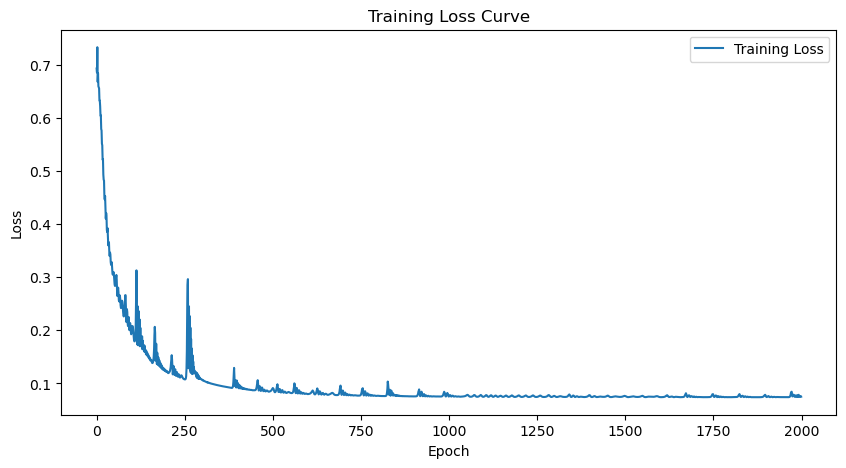

Final Model Accuracy: 81.58%
Final Model F1-score: 0.8325


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.80       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.84      0.82      0.81       380



/tmp/ipykernel_206723/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
